# The Evaluation of Crime Threat for Venues in San Francisco City

- by John Chao
- April 21, 2021

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data Acquisition and Solution](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction
### Background
There were many public venues unexpectedly suffered a loss caused by criminal incidents every day. Are stakeholders of every single venue aware of the threat level in their vicinities? Do they evaluate the public security is based on their feeling or data driven?
### Problem
We already know there are some statistics available, and which is divided by district. The district is a broad scope with hundreds or thousands of venues, a venue where is sited in a good public security district would be less threat level than others in a poor public security district? Is this a fair judgement? In addition, the type of criminal incidents affect business differently, thus what type of criminal incidents occurred nearby is an important indicator too. This project aims to provide an evaluation of the crime threats to each venue in the radius of 50 meters.
### Interest
Most insurance companies would be immensely interested to know the accurate threat level for each of venues; they can offer customized rates based on criminal types and frequency within the 50-meter radius. It means insurance companies can generate a strategic marketing plan and offer aggressive rates to their existing or potential customers with less risks as they have massive information to support the decision. Besides, real estate agencies and merchants will show huge interest in this project too.

## Data acquisition and Solution
### Data sources
First of all, we need the incident report from Police Department of San Francisco which shall include incident date, type, coordinates, and so on. It can be found from DataSF (http:data.sfgov.org), however I chose to retrieve dataset from IBM Developer Skills Network where provides data narrowed down to what I need mostly. (Data links)
I would use 2016 dataset to instantiate the project. In addition to the incident report, we also need venues information including name, location, and coordinates which we can retrieve through Foursqure API.
### Solution
Now the answer has been buried under massive datasets. Once we get the crime incident report released by Police Dept of San Francisco and  the venue info within the 50-meter radius to each of incidents through Foursquare API, we can analysis the cross-reference to find out the correlation between Crime Incident and Venue. At last, we can conclude the measurement of Thread Level for each of venue.




Import all necessary liberary

In [37]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from folium import plugins

print('Libraries imported.')

Libraries imported.


In [38]:
#set width of display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Part-I Collecting and Cleaning San Francisco Crime data
#### Firstly, let's download criminal incidents of San Francisco(yr2016) from IBM Developer Skills Network.

In [50]:
url= 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/Police_Department_Incidents_-_Previous_Year__2016_.csv'

df_incidents= pd.read_csv(url)

df_incidents.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,120058272,WEAPON LAWS,POSS OF PROHIBITED WEAPON,Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212120
1,120058272,WEAPON LAWS,"FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE",Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212168
2,141059263,WARRANTS,WARRANT ARREST,Monday,04/25/2016 12:00:00 AM,14:59,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,-122.388856,37.729981,"(37.7299809672996, -122.388856204292)",14105926363010
3,160013662,NON-CRIMINAL,LOST PROPERTY,Tuesday,01/05/2016 12:00:00 AM,23:50,TENDERLOIN,NONE,JONES ST / OFARRELL ST,-122.412971,37.785788,"(37.7857883766888, -122.412970537591)",16001366271000
4,160002740,NON-CRIMINAL,LOST PROPERTY,Friday,01/01/2016 12:00:00 AM,00:30,MISSION,NONE,16TH ST / MISSION ST,-122.419672,37.765050,"(37.7650501214668, -122.419671780296)",16000274071000


In [51]:
df_incidents.shape

(150500, 13)

##### Although there are total 150,500 incidents, we only choose first 1500 incidents as the sample dataset due to the limitation of a Foursquare free account.

In [52]:
df_incidents=df_incidents.iloc[0:1500, :]

In [54]:
# let's see how many categories verus incidents that we have. 
df_incidents.groupby('Category').count()

,IncidntNum,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
Category,,,,,,,,,,,,
ARSON,6,6,6,6,6,6,6,6,6,6,6,6
ASSAULT,160,160,160,160,160,160,160,160,160,160,160,160
BRIBERY,1,1,1,1,1,1,1,1,1,1,1,1
BURGLARY,90,90,90,90,90,90,90,90,90,90,90,90
DISORDERLY CONDUCT,6,6,6,6,6,6,6,6,6,6,6,6
DRIVING UNDER THE INFLUENCE,5,5,5,5,5,5,5,5,5,5,5,5
DRUG/NARCOTIC,50,50,50,50,50,50,50,50,50,50,50,50
DRUNKENNESS,10,10,10,10,10,10,10,10,10,10,10,10
EMBEZZLEMENT,2,2,2,2,2,2,2,2,2,2,2,2


In [55]:
# 'OTHER OFFENSES'and 'NON-CRIMINAL' are not well difined categories, I decide to removed them. 
df_crimes=df_incidents[(df_incidents.Category !='OTHER OFFENSES') & (df_incidents.Category !='NON-CRIMINAL')]
df_crimes.shape

(1125, 13)

In [56]:
# There are 24 categories left, are they all critical? let's sort them by number of incidents to find out.
df_group=df_crimes.groupby('Category').count()
df_sort=df_group.sort_values('IncidntNum', ascending=False)
df_sort.head(15)

,IncidntNum,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
Category,,,,,,,,,,,,
LARCENY/THEFT,243,243,243,243,243,243,243,243,243,243,243,243
ASSAULT,160,160,160,160,160,160,160,160,160,160,160,160
WARRANTS,93,93,93,93,93,93,93,93,93,93,93,93
BURGLARY,90,90,90,90,90,90,90,90,90,90,90,90
VEHICLE THEFT,82,82,82,82,82,82,82,82,82,82,82,82
SUSPICIOUS OCC,69,69,69,69,69,69,69,69,69,69,69,69
VANDALISM,59,59,59,59,59,59,59,59,59,59,59,59
MISSING PERSON,50,50,50,50,50,50,50,50,50,50,50,50
DRUG/NARCOTIC,50,50,50,50,50,50,50,50,50,50,50,50


#### Let's filted out 7 types/cateogries of crime incidents that have most influence on venues' security.

In [57]:
threat_cat=['LARCENY/THEFT','ASSAULT', 'VANDALISM','BURGLARY','DRUG/NARCOTIC','ROBBERY','TRESPASS']
df_threats=pd.DataFrame(columns=df_crimes.columns)
for i in threat_cat:
    df_temp=df_crimes[(df_crimes.Category == i)]
    df_threats=df_threats.append(df_temp)

df_threats.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
10,160086863,LARCENY/THEFT,ATTEMPTED THEFT FROM LOCKED VEHICLE,Friday,01/29/2016 12:00:00 AM,22:30,TARAVAL,NONE,1200 Block of 19TH AV,-122.477377,37.764478,"(37.7644781578695, -122.477376524003)",16008686306240
19,160004837,LARCENY/THEFT,PETTY THEFT SHOPLIFTING,Saturday,01/02/2016 12:00:00 AM,17:39,SOUTHERN,JUVENILE BOOKED,900 Block of MARKET ST,-122.408421,37.783570,"(37.7835699386918, -122.408421116922)",16000483706362
32,160138652,LARCENY/THEFT,PETTY THEFT SHOPLIFTING,Tuesday,02/16/2016 12:00:00 AM,12:40,INGLESIDE,NONE,3300 Block of MISSION ST,-122.421128,37.743555,"(37.7435550542265, -122.421128029505)",16013865206362
42,160010505,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,01/04/2016 12:00:00 AM,19:40,MISSION,NONE,2300 Block of 16TH ST,-122.409530,37.765718,"(37.7657184395282, -122.409529913278)",16001050506244
61,160012028,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,01/05/2016 12:00:00 AM,14:00,PARK,NONE,DIVISADERO ST / HAYES ST,-122.437800,37.774991,"(37.7749912944366, -122.437799703468)",16001202806244


In [58]:
df_threats.reset_index(drop=True, inplace=True)

In [59]:
df_threats.shape

(670, 13)

#### We got 670 incidents ready to explore the nearby venues later on.

### Let's superimpose incidetns on the map
- Firstly, we need to get the geographical coordinates of San Francisco

In [60]:
address_ = 'San Francisco, CA'

geolocator= Nominatim(user_agent='sf_explorer')
location= geolocator.geocode(address_)
latitude= location.latitude
longitude= location.longitude
print('The geograpical coordinate of San Francisco are {},{}.'.format(latitude, longitude))

The geograpical coordinate of San Francisco are 37.7790262,-122.419906.


In [61]:
# create map
sanfran_map= folium.Map(location=[latitude, longitude], zoom_start=12)

from folium import plugins

# instantiate a mark cluster object for the incidents in the dataframe
incidents= plugins.MarkerCluster().add_to(sanfran_map)

# loop through all crime incidents and add each to the mark cluster
for lat, lng, label in zip(df_threats.Y, df_threats.X, df_threats.Category):
    folium.Marker([lat,lng], icon=None, popup=label).add_to(incidents)
 
sanfran_map

### Part II Let's retrieve venues data of San Francisco from Foursquare

In [62]:
# Define Foursquare credential and version
CLIENT_ID = '4M2MNBPWHXCA1YVIU3XZ4DGS0YZAWJNAZ503WXHXC4JSWNVU' 
CLIENT_SECRET = 'WEFLCGUPCUZWV3D5BYGCU0HDUEYEJHJQTR4IZ5NXWK43IIOU' 
VERSION = '20161231' # Foursquare API version


In [65]:
# let's testing data can be explored appropriately in the 500 meter radius of San Francisco.
LIMIT=50
radius= '500'
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=4M2MNBPWHXCA1YVIU3XZ4DGS0YZAWJNAZ503WXHXC4JSWNVU&client_secret=WEFLCGUPCUZWV3D5BYGCU0HDUEYEJHJQTR4IZ5NXWK43IIOU&ll=37.7790262,-122.419906&v=20161231&radius=500&limit=50'

In [66]:
# Testing if foursqure response correctly
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '608239615d3cab49438ca0ec'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Civic Center',
  'headerFullLocation': 'Civic Center, San Francisco',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 109,
  'suggestedBounds': {'ne': {'lat': 37.7835262045, 'lng': -122.41422315588267},
   'sw': {'lat': 37.774526195499995, 'lng': -122.42558884411733}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4aa48566f964a520024720e3',
       'name': 'Louise M. Davies Symphony Hall',
       'contact': {},
       'location': {'address': '201 Van Ness Ave',
        'crossStreet': 'btwn Grove & Hayes St',
     

In [17]:

# There is the personal account which is still free, and with it you get 99,500 regular calls and 500 premium calls. That is actually 100 times more calls than the default sandbox account. You'll also get access to over 105 million venues or points of interest, but you still only get two photos and two tips per venue

In [67]:
# let's write a function to loop through all incidents and get venues in the radius of 50 meters
def getNearbyVenues(names, latitudes, longitudes, radius=50):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
                   
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['location']['formattedAddress'][0], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Crime_cat', 
                  'Crime_lat', 
                  'Crime_lon', 
                  'Venue',
                  'Venue_Add',
                  'Venue_Lat', 
                  'Venue_Lon', 
                  'Venue_Cat']
    
    return(nearby_venues)

In [68]:
# Generate a dataframe combined with incidents and nearby venues.
crime_nearby= getNearbyVenues(df_threats['Category'], df_threats['Y'], df_threats['X'])
crime_nearby

,Crime_cat,Crime_lat,Crime_lon,Venue,Venue_Add,Venue_Lat,Venue_Lon,Venue_Cat
0,LARCENY/THEFT,37.743555,-122.421128,Taqueria La Alteña,3348 Mission St (btw 29th St & Godeus St),37.743274,-122.421552,Mexican Restaurant
1,LARCENY/THEFT,37.743555,-122.421128,Coco's Ramen,3319 Mission St,37.743871,-122.421038,Ramen Restaurant
2,LARCENY/THEFT,37.743555,-122.421128,Pizza Hut,3349 Mission St (at Virginia Ave),37.743253,-122.421165,Pizza Place
3,LARCENY/THEFT,37.743555,-122.421128,Crazy Sushi,3319 Mission St (29th Street),37.743859,-122.421013,Japanese Restaurant
4,LARCENY/THEFT,37.774991,-122.437800,Bi-Rite Market,550 Divisadero St (btwn Hayes St & Fell St),37.774796,-122.437739,Market
...,...,...,...,...,...,...,...,...
1176,TRESPASS,37.742877,-122.478377,Antigua Coffee Shop,1131 Taraval St (btwn 21st & 22nd),37.742913,-122.478482,Café
1177,TRESPASS,37.742877,-122.478377,One Boiling Pot Mixian Noodles,1155 Taraval St (at 22nd Ave),37.742884,-122.478811,Chinese Restaurant
1178,TRESPASS,37.742877,-122.478377,Tennessee Grill,1128 Taraval St,37.743037,-122.478389,American Restaurant
1179,TRESPASS,37.742877,-122.478377,Taraval Pizza,1115 Taraval St,37.742917,-122.478301,Pizza Place


In [69]:
crime_nearby.shape

(1181, 8)

In [70]:
# set up max width and rows to display
pd.options.display.max_rows=500
pd.options.display.max_colwidth=200

### As one venue may have multiple incidents occured within the radius of 50 meters, we shall group these data.

In [71]:
# Create a new column by coordinates, it will be used to group venues later on.
crime_nearby['Venue_Lat2']=crime_nearby['Venue_Lat'].astype(str)
crime_nearby['Venue_Lon2']=crime_nearby['Venue_Lon'].astype(str)
crime_nearby['Venue_cor']=crime_nearby['Venue_Lat2']+','+crime_nearby['Venue_Lon2']
crime_nearby.drop(['Venue_Lat2','Venue_Lon2'], axis=1, inplace=True)
crime_nearby.head()

,Crime_cat,Crime_lat,Crime_lon,Venue,Venue_Add,Venue_Lat,Venue_Lon,Venue_Cat,Venue_cor
0,LARCENY/THEFT,37.743555,-122.421128,Taqueria La Alteña,3348 Mission St (btw 29th St & Godeus St),37.743274,-122.421552,Mexican Restaurant,"37.743274044900836,-122.42155163920445"
1,LARCENY/THEFT,37.743555,-122.421128,Coco's Ramen,3319 Mission St,37.743871,-122.421038,Ramen Restaurant,"37.74387073759982,-122.42103817416697"
2,LARCENY/THEFT,37.743555,-122.421128,Pizza Hut,3349 Mission St (at Virginia Ave),37.743253,-122.421165,Pizza Place,"37.7432530399245,-122.42116503422949"
3,LARCENY/THEFT,37.743555,-122.421128,Crazy Sushi,3319 Mission St (29th Street),37.743859,-122.421013,Japanese Restaurant,"37.74385896174317,-122.42101293134586"
4,LARCENY/THEFT,37.774991,-122.437800,Bi-Rite Market,550 Divisadero St (btwn Hayes St & Fell St),37.774796,-122.437739,Market,"37.77479553269564,-122.4377388357674"


In [168]:
crime_nearby

,Crime_cat,Crime_lat,Crime_lon,Venue,Venue_Add,Venue_Lat,Venue_Lon,Venue_Cat,Venue_cor
0,LARCENY/THEFT,37.743555,-122.421128,Taqueria La Alteña,3348 Mission St (btw 29th St & Godeus St),37.743274,-122.421552,Mexican Restaurant,"37.743274044900836,-122.42155163920445"
1,LARCENY/THEFT,37.743555,-122.421128,Coco's Ramen,3319 Mission St,37.743871,-122.421038,Ramen Restaurant,"37.74387073759982,-122.42103817416697"
2,LARCENY/THEFT,37.743555,-122.421128,Pizza Hut,3349 Mission St (at Virginia Ave),37.743253,-122.421165,Pizza Place,"37.7432530399245,-122.42116503422949"
3,LARCENY/THEFT,37.743555,-122.421128,Crazy Sushi,3319 Mission St (29th Street),37.743859,-122.421013,Japanese Restaurant,"37.74385896174317,-122.42101293134586"
4,LARCENY/THEFT,37.774991,-122.437800,Bi-Rite Market,550 Divisadero St (btwn Hayes St & Fell St),37.774796,-122.437739,Market,"37.77479553269564,-122.4377388357674"
...,...,...,...,...,...,...,...,...,...
1176,TRESPASS,37.742877,-122.478377,Antigua Coffee Shop,1131 Taraval St (btwn 21st & 22nd),37.742913,-122.478482,Café,"37.74291309359446,-122.47848169874514"
1177,TRESPASS,37.742877,-122.478377,One Boiling Pot Mixian Noodles,1155 Taraval St (at 22nd Ave),37.742884,-122.478811,Chinese Restaurant,"37.74288387253323,-122.47881054150487"
1178,TRESPASS,37.742877,-122.478377,Tennessee Grill,1128 Taraval St,37.743037,-122.478389,American Restaurant,"37.743037,-122.478389"
1179,TRESPASS,37.742877,-122.478377,Taraval Pizza,1115 Taraval St,37.742917,-122.478301,Pizza Place,"37.74291711237988,-122.47830060112612"


### Convert incidents to column with frequence of occurance

In [72]:
# one hot encoding
crime_onehot = pd.get_dummies(crime_nearby[['Crime_cat']], prefix="", prefix_sep="")

# add necessary columns back to dataframe
crime_onehot['Venue_Add']= crime_nearby['Venue_Add']
crime_onehot['Venue_Lat']= crime_nearby['Venue_Lat']
crime_onehot['Venue_Lon']= crime_nearby['Venue_Lon']
crime_onehot['Venue_cor'] = crime_nearby['Venue_cor']
crime_onehot['Venue'] = crime_nearby['Venue']


# move Venue column to the first column
fixed_columns = [crime_onehot.columns[-1]] + list(crime_onehot.columns[:-1])
crime_onehot = crime_onehot[fixed_columns]

crime_onehot.head()

,Venue,ASSAULT,BURGLARY,DRUG/NARCOTIC,LARCENY/THEFT,ROBBERY,TRESPASS,VANDALISM,Venue_Add,Venue_Lat,Venue_Lon,Venue_cor
0,Taqueria La Alteña,0,0,0,1,0,0,0,3348 Mission St (btw 29th St & Godeus St),37.743274,-122.421552,"37.743274044900836,-122.42155163920445"
1,Coco's Ramen,0,0,0,1,0,0,0,3319 Mission St,37.743871,-122.421038,"37.74387073759982,-122.42103817416697"
2,Pizza Hut,0,0,0,1,0,0,0,3349 Mission St (at Virginia Ave),37.743253,-122.421165,"37.7432530399245,-122.42116503422949"
3,Crazy Sushi,0,0,0,1,0,0,0,3319 Mission St (29th Street),37.743859,-122.421013,"37.74385896174317,-122.42101293134586"
4,Bi-Rite Market,0,0,0,1,0,0,0,550 Divisadero St (btwn Hayes St & Fell St),37.774796,-122.437739,"37.77479553269564,-122.4377388357674"


In [75]:
crime_onehot.shape

(1181, 12)

In [76]:
# let's create a data frame with basic venue info, it will be used for combination later.
venue_info=crime_onehot.drop(threat_cat, axis=1)
venue_info.head()

,Venue,Venue_Add,Venue_Lat,Venue_Lon,Venue_cor
0,Taqueria La Alteña,3348 Mission St (btw 29th St & Godeus St),37.743274,-122.421552,"37.743274044900836,-122.42155163920445"
1,Coco's Ramen,3319 Mission St,37.743871,-122.421038,"37.74387073759982,-122.42103817416697"
2,Pizza Hut,3349 Mission St (at Virginia Ave),37.743253,-122.421165,"37.7432530399245,-122.42116503422949"
3,Crazy Sushi,3319 Mission St (29th Street),37.743859,-122.421013,"37.74385896174317,-122.42101293134586"
4,Bi-Rite Market,550 Divisadero St (btwn Hayes St & Fell St),37.774796,-122.437739,"37.77479553269564,-122.4377388357674"


In [77]:
# Group the venues by same coordinates
venue_gr = crime_onehot.groupby('Venue_cor').sum().reset_index()
venue_grouped = venue_gr.drop(['Venue_Lat', 'Venue_Lon'],axis=1)
venue_grouped

,Venue_cor,ASSAULT,BURGLARY,DRUG/NARCOTIC,LARCENY/THEFT,ROBBERY,TRESPASS,VANDALISM
0,"37.708502,-122.4058768",0,0,0,0,0,0,1
1,"37.708755108136586,-122.40538060348891",0,0,0,0,0,0,1
2,"37.711177825927734,-122.42073059082031",1,0,0,0,0,0,0
3,"37.71269571589922,-122.44449831219255",0,1,1,0,0,0,0
4,"37.712964536734695,-122.44440749235383",0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...
782,"37.80771944850959,-122.41944500418577",0,0,0,0,1,0,0
783,"37.808395744789735,-122.41261299485446",0,0,1,0,0,0,0
784,"37.808474494099436,-122.41301664585744",0,0,1,0,0,0,0
785,"37.80859406318003,-122.41074859025822",2,0,0,0,0,0,0


** Now we have 787 unique venues

In [109]:
# let's add back Venue info
venues_mer = venue_grouped

# merge venues_mer with venue_info data to add vanue name, address, latitude/longitude for each venue
venues_mer = venues_mer.join(venue_info.set_index('Venue_cor'), on='Venue_cor')

venues_mer.head()

,Venue_cor,ASSAULT,BURGLARY,DRUG/NARCOTIC,LARCENY/THEFT,ROBBERY,TRESPASS,VANDALISM,Venue,Venue_Add,Venue_Lat,Venue_Lon
0,"37.708502,-122.4058768",0,0,0,0,0,0,1,Grocery Outlet,2630 Bayshore Boulevard,37.708502,-122.405877
1,"37.708755108136586,-122.40538060348891",0,0,0,0,0,0,1,Happy Donuts,2600 Bay Shore Blvd (at Sunnydale),37.708755,-122.405381
2,"37.711177825927734,-122.42073059082031",1,0,0,0,0,0,0,Corns car,"San Francisco, CA 94134",37.711178,-122.420731
3,"37.71269571589922,-122.44449831219255",0,1,1,0,0,0,0,MUNI Stop #15589,Mission (Foote),37.712696,-122.444498
3,"37.71269571589922,-122.44449831219255",0,1,1,0,0,0,0,MUNI Stop #15589,Mission (Foote),37.712696,-122.444498


In [113]:
# drop duplicated row caused by merge
venues_mer.drop_duplicates(subset=['Venue_cor'], inplace=True)

# we are no logner need column 'Venue_cor', let's remove it
df_temp_a=venues_mer.drop(['Venue_cor'], axis=1)

# let's re-orgnize the column
df_temp_b=df_temp_a[['Venue','Venue_Add','Venue_Lon','Venue_Lat']]
df_temp_c=df_temp_a.drop(labels=['Venue','Venue_Add','Venue_Lon','Venue_Lat'], axis=1)
df_wt_= pd.concat([df_temp_b, df_temp_c], axis=1, join='inner')
df_wt_.head()


,Venue,Venue_Add,Venue_Lon,Venue_Lat,ASSAULT,BURGLARY,DRUG/NARCOTIC,LARCENY/THEFT,ROBBERY,TRESPASS,VANDALISM
0,Grocery Outlet,2630 Bayshore Boulevard,-122.405877,37.708502,0,0,0,0,0,0,1
1,Happy Donuts,2600 Bay Shore Blvd (at Sunnydale),-122.405381,37.708755,0,0,0,0,0,0,1
2,Corns car,"San Francisco, CA 94134",-122.420731,37.711178,1,0,0,0,0,0,0
3,MUNI Stop #15589,Mission (Foote),-122.444498,37.712696,0,1,1,0,0,0,0
4,Reina's Restaurant,5479 Mission St,-122.444407,37.712965,0,1,1,0,0,0,0


In [80]:
df_wt_.shape

(787, 11)

## Methodology
In this project we will direct our efforts on detecting areas of San Francisco that have crime incidents occurred nearby venues in radius of 50 meters.
This project provides two measurement methods of the crime threat level:
- **Threat Score**—According to the severity of possible damage to venues, I assign weights to each incident category, and then sum up scores for each venue. Higher score means higher threat level. Our clients can decide how to weight on each incident category at their own based on different purpose.
- **Clustering**—We use **k-means clustering** to create clusters and categorize venues into several clusters. We will present map of all venues with their clusters, so our client can observe the correlation between location and crime incidents.



## Analysis

### Let's assign weight to each type of incidents and score the venues

In [117]:
# assign weigths to type of incidents
# from ASSAULT to VANDALISM; here we assing max weights on ROBBERY, clients can set up with their own preference
wt_list=[0.7,0.8,0.3,0.5,1,0.3,0.6]

# let's convert frequecy to weights
for k,j in enumerate(np.arange(4,11)):
    for i in np.arange(df_wt_.shape[0]):
        df_wt_.iloc[i,j]=df_wt_.iloc[i,j]* wt_list[k]

In [118]:
df_wt_.head()

,Venue,Venue_Add,Venue_Lon,Venue_Lat,ASSAULT,BURGLARY,DRUG/NARCOTIC,LARCENY/THEFT,ROBBERY,TRESPASS,VANDALISM,Threat_Score
0,Grocery Outlet,2630 Bayshore Boulevard,-122.405877,37.708502,0.0,0.0,0.0,0.0,0,0.0,0.6,1
1,Happy Donuts,2600 Bay Shore Blvd (at Sunnydale),-122.405381,37.708755,0.0,0.0,0.0,0.0,0,0.0,0.6,1
2,Corns car,"San Francisco, CA 94134",-122.420731,37.711178,0.7,0.0,0.0,0.0,0,0.0,0.0,1
3,MUNI Stop #15589,Mission (Foote),-122.444498,37.712696,0.0,0.8,0.3,0.0,0,0.0,0.0,2
4,Reina's Restaurant,5479 Mission St,-122.444407,37.712965,0.0,0.8,0.3,0.0,0,0.0,0.0,2


In [119]:
#let's add up weights and the result will be 'Threat Score' of each venue
df_wt_["Threat_Score"]=df_wt_[threat_cat].sum(axis=1)
df_wt_

,Venue,Venue_Add,Venue_Lon,Venue_Lat,ASSAULT,BURGLARY,DRUG/NARCOTIC,LARCENY/THEFT,ROBBERY,TRESPASS,VANDALISM,Threat_Score
0,Grocery Outlet,2630 Bayshore Boulevard,-122.405877,37.708502,0.0,0.0,0.0,0.0,0,0.0,0.6,0.6
1,Happy Donuts,2600 Bay Shore Blvd (at Sunnydale),-122.405381,37.708755,0.0,0.0,0.0,0.0,0,0.0,0.6,0.6
2,Corns car,"San Francisco, CA 94134",-122.420731,37.711178,0.7,0.0,0.0,0.0,0,0.0,0.0,0.7
3,MUNI Stop #15589,Mission (Foote),-122.444498,37.712696,0.0,0.8,0.3,0.0,0,0.0,0.0,1.1
4,Reina's Restaurant,5479 Mission St,-122.444407,37.712965,0.0,0.8,0.3,0.0,0,0.0,0.0,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...
782,San Francisco Bicycle Rentals,425 Jefferson St (at The Cannery‎),-122.419445,37.807719,0.0,0.0,0.0,0.0,1,0.0,0.0,1.0
783,CVS pharmacy,1 Jefferson St (Powell St),-122.412613,37.808396,0.0,0.0,0.3,0.0,0,0.0,0.0,0.3
784,Starbucks,49 Jefferson St #P (Powell St),-122.413017,37.808474,0.0,0.0,0.3,0.0,0,0.0,0.0,0.3
785,Sea Lion Statue,The Embarcadero,-122.410749,37.808594,1.4,0.0,0.0,0.0,0,0.0,0.0,1.4


In [130]:
temp_I=df_wt_['Threat_Score']
df_weights=df_wt_.drop(labels=['Threat_Score'], axis=1)
df_weights.insert(4,'Threat_Score', temp_I)
df_weights

,Venue,Venue_Add,Venue_Lon,Venue_Lat,Threat_Score,ASSAULT,BURGLARY,DRUG/NARCOTIC,LARCENY/THEFT,ROBBERY,TRESPASS,VANDALISM
0,Grocery Outlet,2630 Bayshore Boulevard,-122.405877,37.708502,0.6,0.0,0.0,0.0,0.0,0,0.0,0.6
1,Happy Donuts,2600 Bay Shore Blvd (at Sunnydale),-122.405381,37.708755,0.6,0.0,0.0,0.0,0.0,0,0.0,0.6
2,Corns car,"San Francisco, CA 94134",-122.420731,37.711178,0.7,0.7,0.0,0.0,0.0,0,0.0,0.0
3,MUNI Stop #15589,Mission (Foote),-122.444498,37.712696,1.1,0.0,0.8,0.3,0.0,0,0.0,0.0
4,Reina's Restaurant,5479 Mission St,-122.444407,37.712965,1.1,0.0,0.8,0.3,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
782,San Francisco Bicycle Rentals,425 Jefferson St (at The Cannery‎),-122.419445,37.807719,1.0,0.0,0.0,0.0,0.0,1,0.0,0.0
783,CVS pharmacy,1 Jefferson St (Powell St),-122.412613,37.808396,0.3,0.0,0.0,0.3,0.0,0,0.0,0.0
784,Starbucks,49 Jefferson St #P (Powell St),-122.413017,37.808474,0.3,0.0,0.0,0.3,0.0,0,0.0,0.0
785,Sea Lion Statue,The Embarcadero,-122.410749,37.808594,1.4,1.4,0.0,0.0,0.0,0,0.0,0.0


In [127]:
# Let's find out how many different scores in data frame.
print('The dataframe has {} venues with {} different scores.'.format(
        df_weights.shape[0], len(df_weights['Threat_Score'].unique())
    )
)

The dataframe has 787 venues with 33 different scores.


In [141]:
# Let's have a closer look at the Threat_Score distribution.
df_tempII=df_weights.groupby('Threat_Score').count()
df_wt_sort=df_tempII.reset_index()
df_wt_sort

,Threat_Score,Venue,Venue_Add,Venue_Lon,Venue_Lat,ASSAULT,BURGLARY,DRUG/NARCOTIC,LARCENY/THEFT,ROBBERY,TRESPASS,VANDALISM
0,0.3,36,36,36,36,36,36,36,36,36,36,36
1,0.5,250,250,250,250,250,250,250,250,250,250,250
2,0.6,52,52,52,52,52,52,52,52,52,52,52
3,0.7,110,110,110,110,110,110,110,110,110,110,110
4,0.8,92,92,92,92,92,92,92,92,92,92,92
5,0.9,3,3,3,3,3,3,3,3,3,3,3
6,1.0,81,81,81,81,81,81,81,81,81,81,81
7,1.1,9,9,9,9,9,9,9,9,9,9,9
8,1.2,7,7,7,7,7,7,7,7,7,7,7
9,1.3,17,17,17,17,17,17,17,17,17,17,17


In [149]:
# Let's visualize it.
import plotly.express as px
fig= px.bar(df_wt_sort, x='Threat_Score', y='Venue', title='Threat Score Distribution')
fig.show()

Most venues fell in the score range 0.3 to 1; score of 0.5 is most common score with 250 venues which takes 32% of total venues.

In [129]:
# let's export data frame to .csv to help us observe the result
df_weights.to_csv('df_weights.csv')

### Let's find out the most common incidents for each venue

In [84]:
def return_most_common_inc(row, num_top_venues):
    row_venues_sorted= row.sort_values(ascending=False)
    
    return row_venues_sorted.index.values[0:num_top_venues]

In [150]:
venue_grouped.head()

,Venue_cor,ASSAULT,BURGLARY,DRUG/NARCOTIC,LARCENY/THEFT,ROBBERY,TRESPASS,VANDALISM
0,"37.708502,-122.4058768",0,0,0,0,0,0,1
1,"37.708755108136586,-122.40538060348891",0,0,0,0,0,0,1
2,"37.711177825927734,-122.42073059082031",1,0,0,0,0,0,0
3,"37.71269571589922,-122.44449831219255",0,1,1,0,0,0,0
4,"37.712964536734695,-122.44440749235383",0,1,1,0,0,0,0


In [86]:
num_top_venues= venue_grouped.shape[1]-1

indicators= ['st','nd','rd']

# create columns according to number of top incidents
columns=['Venue_cor']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Incident'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Incident'.format(ind+1))

# create a new dataframe
venues_common_inc= pd.DataFrame(columns=columns)
venues_common_inc['Venue_cor']= venue_grouped['Venue_cor']

for ind in np.arange(venue_grouped.shape[0]):
    venues_common_inc.iloc[ind,1:]= return_most_common_inc(venue_grouped.iloc[ind, 1:], num_top_venues)

In [170]:
venues_common_inc.head()

,Cluster_Labels,Venue_cor,1st Most Common Incident,2nd Most Common Incident,3rd Most Common Incident,4th Most Common Incident,5th Most Common Incident,6th Most Common Incident,7th Most Common Incident
0,0,"37.708502,-122.4058768",VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
1,0,"37.708755108136586,-122.40538060348891",VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
2,5,"37.711177825927734,-122.42073059082031",ASSAULT,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY
3,3,"37.71269571589922,-122.44449831219255",DRUG/NARCOTIC,BURGLARY,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,ASSAULT
4,3,"37.712964536734695,-122.44440749235383",DRUG/NARCOTIC,BURGLARY,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,ASSAULT


### Cluster Venues

### Run K-means to cluster the venues

In [88]:
Clus_dataSet=venue_grouped.drop('Venue_cor',1)

In [89]:
# Normalization over the standard deviation
from sklearn.preprocessing import StandardScaler
X = Clus_dataSet.values[:,:]
X = np.nan_to_num(X)
venue_clustering = StandardScaler().fit_transform(X)
venue_clustering[0:5]

array([[-0.55121835, -0.41082266, -0.29545529, -0.68789228, -0.32470938,
        -0.22322865,  2.50145472],
       [-0.55121835, -0.41082266, -0.29545529, -0.68789228, -0.32470938,
        -0.22322865,  2.50145472],
       [ 0.96559578, -0.41082266, -0.29545529, -0.68789228, -0.32470938,
        -0.22322865, -0.31895339],
       [-0.55121835,  2.00199402,  1.79934933, -0.68789228, -0.32470938,
        -0.22322865, -0.31895339],
       [-0.55121835,  2.00199402,  1.79934933, -0.68789228, -0.32470938,
        -0.22322865, -0.31895339]])

### Find the optimal k

In [90]:
# Find best K
distortions=[]
K= range(1,10)
for k in K:
    kmeanModel= KMeans(n_clusters=k)
    kmeanModel.fit(venue_clustering)
    distortions.append(kmeanModel.inertia_)

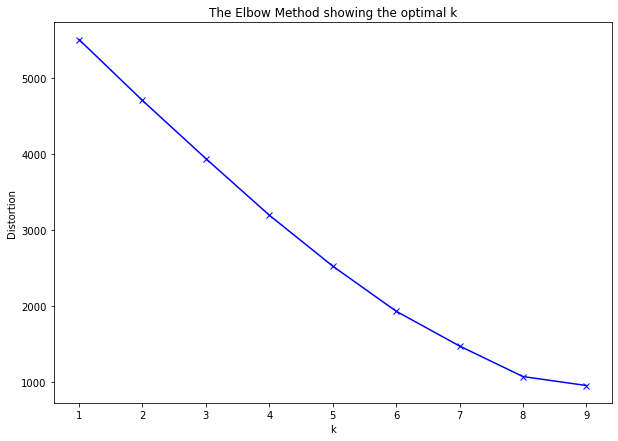

In [91]:
plt.figure(figsize=(10,7))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Run K-means to cluster the venues into 6 clusters

In [92]:
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=4).fit(venue_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:50]

array([0, 0, 5, 3, 3, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5,
       3, 5, 5, 5, 4, 5, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0,
       0, 0, 0, 0, 0, 0])

In [93]:
# add clustering labels
venues_common_inc.insert(0, 'Cluster_Labels', kmeans.labels_)

venues_merged = venues_common_inc

# merge venues_merged with venue_info data to add vanue name, address, latitude/longitude for each venue
venues_merged = venues_merged.join(venue_info.set_index('Venue_cor'), on='Venue_cor')

venues_merged.head()

,Cluster_Labels,Venue_cor,1st Most Common Incident,2nd Most Common Incident,3rd Most Common Incident,4th Most Common Incident,5th Most Common Incident,6th Most Common Incident,7th Most Common Incident,Venue,Venue_Add,Venue_Lat,Venue_Lon
0,0,"37.708502,-122.4058768",VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT,Grocery Outlet,2630 Bayshore Boulevard,37.708502,-122.405877
1,0,"37.708755108136586,-122.40538060348891",VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT,Happy Donuts,2600 Bay Shore Blvd (at Sunnydale),37.708755,-122.405381
2,5,"37.711177825927734,-122.42073059082031",ASSAULT,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,Corns car,"San Francisco, CA 94134",37.711178,-122.420731
3,3,"37.71269571589922,-122.44449831219255",DRUG/NARCOTIC,BURGLARY,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,ASSAULT,MUNI Stop #15589,Mission (Foote),37.712696,-122.444498
3,3,"37.71269571589922,-122.44449831219255",DRUG/NARCOTIC,BURGLARY,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,ASSAULT,MUNI Stop #15589,Mission (Foote),37.712696,-122.444498


In [94]:
venues_merged.shape

(1181, 13)

In [95]:
# drop duplicated row caused by merge
venues_merged.drop_duplicates(subset=['Venue_cor'], inplace=True)

In [96]:
venues_merged.shape

(787, 13)

In [97]:
df_temp1=venues_merged.drop(['Venue_cor'], axis=1)

In [98]:
df_temp2=df_temp1[['Venue','Venue_Add','Venue_Lon','Venue_Lat']]
df_temp3=df_temp1.drop(labels=['Venue','Venue_Add','Venue_Lon','Venue_Lat'], axis=1)
df_combine= pd.concat([df_temp2, df_temp3], axis=1, join='inner')
df_combine.head()

,Venue,Venue_Add,Venue_Lon,Venue_Lat,Cluster_Labels,1st Most Common Incident,2nd Most Common Incident,3rd Most Common Incident,4th Most Common Incident,5th Most Common Incident,6th Most Common Incident,7th Most Common Incident
0,Grocery Outlet,2630 Bayshore Boulevard,-122.405877,37.708502,0,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
1,Happy Donuts,2600 Bay Shore Blvd (at Sunnydale),-122.405381,37.708755,0,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
2,Corns car,"San Francisco, CA 94134",-122.420731,37.711178,5,ASSAULT,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY
3,MUNI Stop #15589,Mission (Foote),-122.444498,37.712696,3,DRUG/NARCOTIC,BURGLARY,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,ASSAULT
4,Reina's Restaurant,5479 Mission St,-122.444407,37.712965,3,DRUG/NARCOTIC,BURGLARY,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,ASSAULT


In [172]:
df_combine

,Venue,Venue_Add,Venue_Lon,Venue_Lat,Cluster_Labels,1st Most Common Incident,2nd Most Common Incident,3rd Most Common Incident,4th Most Common Incident,5th Most Common Incident,6th Most Common Incident,7th Most Common Incident
0,Grocery Outlet,2630 Bayshore Boulevard,-122.405877,37.708502,0,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
1,Happy Donuts,2600 Bay Shore Blvd (at Sunnydale),-122.405381,37.708755,0,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
2,Corns car,"San Francisco, CA 94134",-122.420731,37.711178,5,ASSAULT,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY
3,MUNI Stop #15589,Mission (Foote),-122.444498,37.712696,3,DRUG/NARCOTIC,BURGLARY,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,ASSAULT
4,Reina's Restaurant,5479 Mission St,-122.444407,37.712965,3,DRUG/NARCOTIC,BURGLARY,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,ASSAULT
...,...,...,...,...,...,...,...,...,...,...,...,...
782,San Francisco Bicycle Rentals,425 Jefferson St (at The Cannery‎),-122.419445,37.807719,4,ROBBERY,VANDALISM,TRESPASS,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
783,CVS pharmacy,1 Jefferson St (Powell St),-122.412613,37.808396,1,DRUG/NARCOTIC,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,BURGLARY,ASSAULT
784,Starbucks,49 Jefferson St #P (Powell St),-122.413017,37.808474,1,DRUG/NARCOTIC,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,BURGLARY,ASSAULT
785,Sea Lion Statue,The Embarcadero,-122.410749,37.808594,5,ASSAULT,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY


### Let's visualize the resulting clusters

In [99]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_combine['Venue_Lat'], df_combine['Venue_Lon'], df_combine['Venue'], df_combine['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine CLusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

#### Cluster 1

In [152]:
df_cluster1=df_combine.loc[df_combine['Cluster_Labels'] == 0, df_combine.columns[[0] + list(range(5, df_combine.shape[1]))]]
df_cluster1

,Venue,1st Most Common Incident,2nd Most Common Incident,3rd Most Common Incident,4th Most Common Incident,5th Most Common Incident,6th Most Common Incident,7th Most Common Incident
0,Grocery Outlet,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
1,Happy Donuts,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
5,Utilikilts,LARCENY/THEFT,VANDALISM,TRESPASS,ROBBERY,DRUG/NARCOTIC,BURGLARY,ASSAULT
6,Taqueria Los Amigos,LARCENY/THEFT,VANDALISM,TRESPASS,ROBBERY,DRUG/NARCOTIC,BURGLARY,ASSAULT
7,Quickly 快可立,LARCENY/THEFT,VANDALISM,TRESPASS,ROBBERY,DRUG/NARCOTIC,BURGLARY,ASSAULT
8,Taqueria Reinas,LARCENY/THEFT,VANDALISM,TRESPASS,ROBBERY,DRUG/NARCOTIC,BURGLARY,ASSAULT
9,Emergency Plumbers,LARCENY/THEFT,VANDALISM,TRESPASS,ROBBERY,DRUG/NARCOTIC,BURGLARY,ASSAULT
10,Debbie does Dinner,LARCENY/THEFT,VANDALISM,TRESPASS,ROBBERY,DRUG/NARCOTIC,BURGLARY,ASSAULT
43,JJ Fish & Chicken,LARCENY/THEFT,ASSAULT,VANDALISM,TRESPASS,ROBBERY,DRUG/NARCOTIC,BURGLARY
44,One Waan Thai Restaurant,LARCENY/THEFT,VANDALISM,TRESPASS,ROBBERY,DRUG/NARCOTIC,BURGLARY,ASSAULT


In [153]:
df_cluster1.shape

(342, 8)

#### Cluster2

In [154]:
df_Cluster2= df_combine.loc[df_combine['Cluster_Labels'] == 1, df_combine.columns[[0] + list(range(5, df_combine.shape[1]))]]
df_Cluster2

,Venue,1st Most Common Incident,2nd Most Common Incident,3rd Most Common Incident,4th Most Common Incident,5th Most Common Incident,6th Most Common Incident,7th Most Common Incident
58,49ers Food & Liquor,DRUG/NARCOTIC,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,BURGLARY,ASSAULT
156,Red Poppy Art House,DRUG/NARCOTIC,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,BURGLARY,ASSAULT
189,Lazy Bear,DRUG/NARCOTIC,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,BURGLARY,ASSAULT
190,Taqueria Cancún,DRUG/NARCOTIC,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,BURGLARY,ASSAULT
205,Bhoga,LARCENY/THEFT,DRUG/NARCOTIC,ASSAULT,VANDALISM,TRESPASS,ROBBERY,BURGLARY
206,Body Clothing,LARCENY/THEFT,DRUG/NARCOTIC,ASSAULT,VANDALISM,TRESPASS,ROBBERY,BURGLARY
207,440 Castro,LARCENY/THEFT,DRUG/NARCOTIC,ASSAULT,VANDALISM,TRESPASS,ROBBERY,BURGLARY
208,The Cove on Castro,LARCENY/THEFT,DRUG/NARCOTIC,ASSAULT,VANDALISM,TRESPASS,ROBBERY,BURGLARY
209,Castro Theatre,LARCENY/THEFT,DRUG/NARCOTIC,ASSAULT,VANDALISM,TRESPASS,ROBBERY,BURGLARY
210,Rossi's Deli,LARCENY/THEFT,DRUG/NARCOTIC,ASSAULT,VANDALISM,TRESPASS,ROBBERY,BURGLARY


In [155]:
df_Cluster2.shape

(66, 8)

#### Cluster3

In [157]:
df_cluster3=df_combine.loc[df_combine['Cluster_Labels'] == 2, df_combine.columns[[0] + list(range(5, df_combine.shape[1]))]]
df_cluster3

,Venue,1st Most Common Incident,2nd Most Common Incident,3rd Most Common Incident,4th Most Common Incident,5th Most Common Incident,6th Most Common Incident,7th Most Common Incident
65,The Deli King,TRESPASS,VANDALISM,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
66,Dumpling Specialist,TRESPASS,VANDALISM,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
67,One Boiling Pot Mixian Noodles,TRESPASS,VANDALISM,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
68,Antigua Coffee Shop,TRESPASS,VANDALISM,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
70,Taraval Pizza,TRESPASS,VANDALISM,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
71,Banhwich,TRESPASS,VANDALISM,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
72,Super Cue Cafe,TRESPASS,VANDALISM,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
76,Tennessee Grill,TRESPASS,VANDALISM,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
133,Dirty Pigeon,TRESPASS,VANDALISM,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
147,Junior,TRESPASS,VANDALISM,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT


In [158]:
df_cluster3.shape

(39, 8)

#### Cluster4

In [159]:
df_cluster4=df_combine.loc[df_combine['Cluster_Labels'] == 3, df_combine.columns[[0] + list(range(5, df_combine.shape[1]))]]
df_cluster4

,Venue,1st Most Common Incident,2nd Most Common Incident,3rd Most Common Incident,4th Most Common Incident,5th Most Common Incident,6th Most Common Incident,7th Most Common Incident
3,MUNI Stop #15589,DRUG/NARCOTIC,BURGLARY,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,ASSAULT
4,Reina's Restaurant,DRUG/NARCOTIC,BURGLARY,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,ASSAULT
18,Gym @ Park Merced,BURGLARY,ASSAULT,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC
22,Excelsior Playground,BURGLARY,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,ASSAULT
89,Doma Sushi Bar,BURGLARY,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,ASSAULT
95,Noe's Nest Bed & Breakfast,BURGLARY,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,ASSAULT
196,N-Judah 34th Ave,BURGLARY,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,ASSAULT
217,Curry Up Now,BURGLARY,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,ASSAULT
235,Community Thrift Store,BURGLARY,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,ASSAULT
236,Clarion Alley,BURGLARY,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,ASSAULT


In [160]:
df_cluster4.shape

(120, 8)

#### Cluster5

In [161]:
df_cluster5=df_combine.loc[df_combine['Cluster_Labels'] == 4, df_combine.columns[[0] + list(range(5, df_combine.shape[1]))]]
df_cluster5

,Venue,1st Most Common Incident,2nd Most Common Incident,3rd Most Common Incident,4th Most Common Incident,5th Most Common Incident,6th Most Common Incident,7th Most Common Incident
26,Chef Hunan,ROBBERY,VANDALISM,TRESPASS,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
28,Walgreens,ROBBERY,VANDALISM,TRESPASS,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
29,Goodwill Industries,ROBBERY,VANDALISM,TRESPASS,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
30,Wells Fargo,ROBBERY,VANDALISM,TRESPASS,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
60,T Line,ROBBERY,VANDALISM,TRESPASS,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY,ASSAULT
78,Pizza Hut,LARCENY/THEFT,ASSAULT,ROBBERY,VANDALISM,TRESPASS,DRUG/NARCOTIC,BURGLARY
79,Taqueria La Alteña,LARCENY/THEFT,ASSAULT,ROBBERY,VANDALISM,TRESPASS,DRUG/NARCOTIC,BURGLARY
82,Crazy Sushi,LARCENY/THEFT,ASSAULT,ROBBERY,VANDALISM,TRESPASS,DRUG/NARCOTIC,BURGLARY
83,Coco's Ramen,LARCENY/THEFT,ASSAULT,ROBBERY,VANDALISM,TRESPASS,DRUG/NARCOTIC,BURGLARY
90,The Salvation Army,ROBBERY,ASSAULT,VANDALISM,TRESPASS,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY


In [162]:
df_cluster5.shape

(79, 8)

#### Cluster6

In [163]:
df_cluster6=df_combine.loc[df_combine['Cluster_Labels'] == 5, df_combine.columns[[0] + list(range(5, df_combine.shape[1]))]]
df_cluster6

,Venue,1st Most Common Incident,2nd Most Common Incident,3rd Most Common Incident,4th Most Common Incident,5th Most Common Incident,6th Most Common Incident,7th Most Common Incident
2,Corns car,ASSAULT,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY
11,Walgreens,ASSAULT,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY
12,Nameless Tea & Coffee,ASSAULT,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY
13,Little Caesars Pizza,ASSAULT,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY
14,Claddagh Coffee,ASSAULT,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY
15,Alice Griffith Community Garden,ASSAULT,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY
16,Super Star Restaurant,ASSAULT,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY
17,MUNI Bus Stop - Geneva & San Jose,ASSAULT,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY
19,Beach Yard,ASSAULT,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY
20,Geneva Station Cafe,ASSAULT,VANDALISM,TRESPASS,ROBBERY,LARCENY/THEFT,DRUG/NARCOTIC,BURGLARY


In [164]:
df_cluster6.shape

(141, 8)

## Results and Discussion

My analysis shows total 787 venues have been exposed under several types of threat level. In order to get a fair result, I approach them from two perspectives, one is to calculate Threat Score for each venue, another to create Clusters to find out the similarity of venues.
For the approach of Threat Score, most venues fell in the score range 0.3 to 1; score 0.5 is most common score which has pocketed 250 venues, it takes 32% of total share.

As to Clusters, the result categorized 787 venues into 6 clusters:
- a.	Cluster 1—This is largest group packed with 342 venues, takes 43.5%. LARCENY/THEFT is mainstream followed by VANDALISM, then TRESPASS.
- b.	Cluster 2—It is included 66 venues (8.4%) which are mainly DRUG/NARCOTIC, followed by ASSAULT and VANDALISM. 
- c.	Cluster 3—This group has 39 venues (5%). Most common incident is TRESPASS, then VANDALISM and ROBBERY. This is the group having a higher threat level as ROBBERY involved.
- d.	Cluster 4—This is third largest group gathered 120 venues (15.2%). It is consisting of BURGLARY and VANDALISM as majority. Venues in this group may be imposed a significant loss from an incident.
- e.	Cluster 5—There are 79 venues (10%) in this cluster. The first place is taken by ROBBERY, followed by ASSAULT and VANDALISM. Obviously, this is the most violent group with highest threat in the loss of damage.
- f.	Cluster 6—This is secondary largest group packed 141 venues (17.9%). The first most common criminal incident is ASSAULT, and then followed by VANDALISM. Although ASSAULT and VANDALISM may not necessarily happen inside stores, it still alert that venues are surrounding in the environment with violent intense.


## Conclusion

The purpose of this project is to provide our clients reliable indicators that may help them to evaluate the potential loss caused by crime incidents for each of venues in San Francisco. Typically, the risk is measured by the security of district or neighborhood, but we have raised a question: “A venue where is sited in a good public security district would be less threat level than others in a poor public security district?” We got the answer while observing the cluster distribution on map. Our data shows 6 clusters are basically distributed evenly in each district or neighborhood; thus, we cannot tell a venue in a poor public security district faces more crime threats than better public security area. Instead, we narrowed down the affect zone in radius of 50 meters, and provide two indicators, Threat Score and Clusters, which successfully made threat level of every signal venue visible. With these two significant indicators, insurance companies can consolidate with other basic info that they have, such as business type, property value, historic records, etc., to customize the best proposal for each of venues.

The predicting accuracy still have plenty rooms to improve. For instance, more venue data may show more accurate result. This can be improved by acquiring a commercial Foursqure account. Besides, if we can get more details of incidents, such as the loss of dollar amount, it will help too.